# ECCO SALT BUDGET

In [47]:
from dask.distributed import Client

client = Client("tcp://10.32.60.61:40779")
client

Client Scheduler: tcp://10.32.60.61:40779 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 6 Cores: 12 Memory: 69.00 GB


In [48]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

In [49]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [50]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [51]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 26

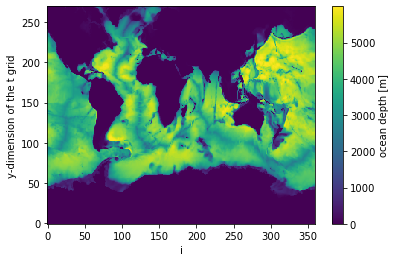

In [52]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=100).drop('i').plot()

In [53]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'k', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [54]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<shap

In [55]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
# Rename time (and iter) axis
dt = dt.rename({'time_snp':'time'})
# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}
ds.dt

<xarray.DataArray 'dt' (time: 288)>
array([     nan, 2505600., 2678400., ..., 2678400., 2592000.,      nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
Attributes:
    units:          s
    standard_name:  dt
    coordinate:     time
    long_name:      time span between snapshots

## Salt budget for WG (entire water column)

In [56]:
sss_mean = ds.SALT.isel(k=0).mean(dim='time').load()

In [57]:
surface_mask = (coords.hFacC[0]>0).load()
surface_mask

<xarray.DataArray 'hFacC' (j: 270, i: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: j, i

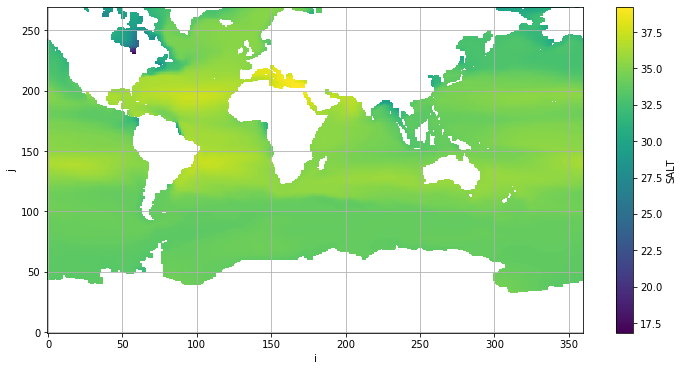

In [58]:
sss_mean.where(surface_mask).plot(figsize=(12,6))
plt.grid();

In [59]:
sss_mean_wg = sss_mean.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg = surface_mask.sel(i=slice(75, 167), j=slice(35, 75))

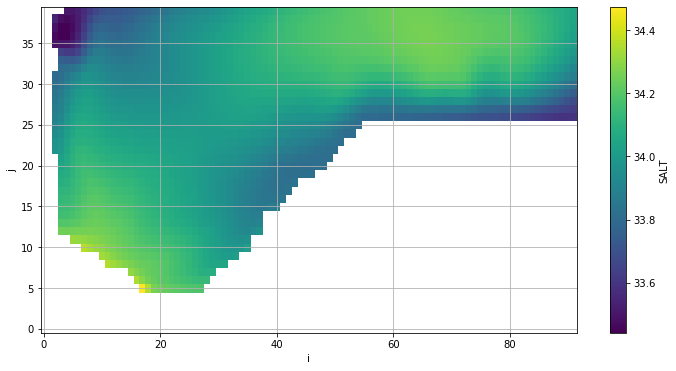

In [60]:
sss_mean_wg.where(surface_mask_wg).plot(figsize=(12,6))
plt.grid();

In [61]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

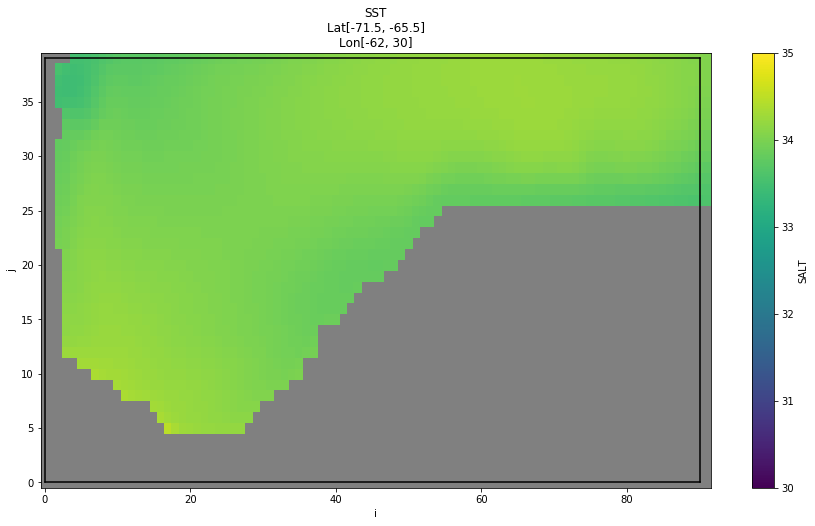

In [62]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sss_mean_wg.where(surface_mask_wg).plot(ax=ax,  vmin=30, vmax=35)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [63]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [64]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [65]:
#advective flux
adv_flux_y = ds.ADVy_SLT.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_SLT.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([1324352., 1503424., -433920., ..., -316416., -614592.,  260352.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

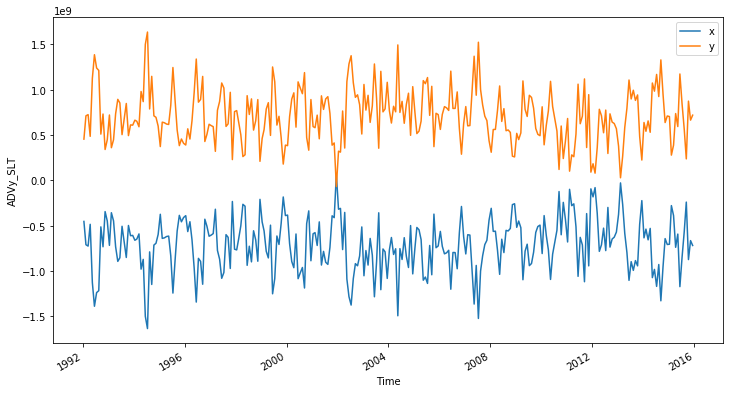

In [66]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [67]:
#diffusive flux
diff_flux_y = ds.DFyE_SLT.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_SLT.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([147818.7 , 158594.86, 158317.27, ..., 175264.4 , 153784.2 , 145433.17],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

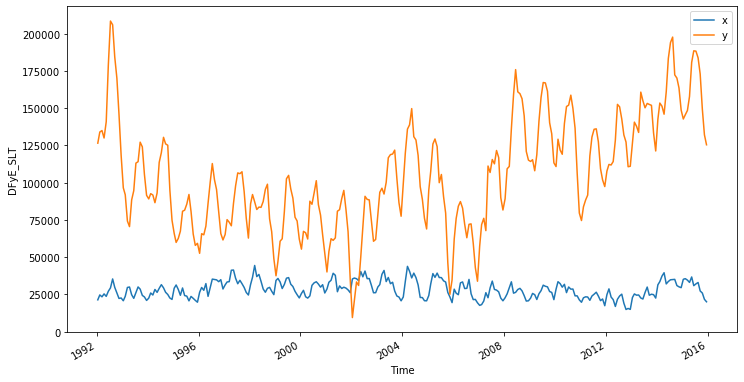

In [68]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

In [69]:
#vertical flux
s_flux_z = (ds.SFLUX * coords.rA * coords.hFacC.isel(k=0)).isel(**lat_range, **lon_range).sum(dim=['i','j'])
s_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 288)>
array([ 4.418436e+08, -4.598768e+08, -3.819659e+09, ..., -1.172409e+09,
       -2.153196e+08,  1.250318e+09], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [70]:
runit2mass = 1.035e3 #kg/m^3
surface_term = s_flux_z / runit2mass

surface_term.load()

#ECCO has nonlinear surface so don't wry about 'lin_fs_correction' term
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([  426902.06,  -444325.4 , -3690491.5 , ..., -1132762.6 ,  -208038.22,
        1208037.  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

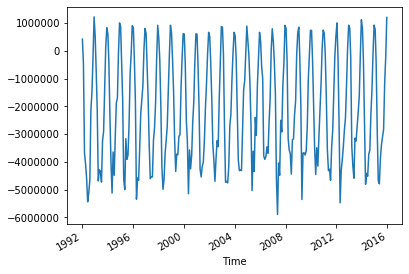

In [71]:
surface_term.plot(label='surf')

In [72]:
salt_scaled = (ds.SALT_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')
salt_scaled

<xarray.DataArray (time_snp: 286, k: 50, j: 270, i: 360)>
dask.array<shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Dimensions without coordinates: k, j, i

In [83]:
ds.SALT_snp

<xarray.DataArray 'SALT_snp' (time_snp: 287, k: 50, j: 270, i: 360)>
dask.array<shape=(287, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Dimensions without coordinates: k, j, i
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [84]:
ds.ETAN_snp

<xarray.DataArray 'ETAN_snp' (time_snp: 287, j: 270, i: 360)>
dask.array<shape=(287, 270, 360), dtype=float32, chunksize=(1, 90, 90)>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Dimensions without coordinates: j, i
Attributes:
    long_name:      Surface Height Anomaly
    standard_name:  ETAN
    units:          m

In [85]:
ds.oceSPtnd

<xarray.DataArray 'oceSPtnd' (time: 288, k: 50, j: 270, i: 360)>
dask.array<shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
Dimensions without coordinates: k, j, i
Attributes:
    long_name:      salt tendency due to salt plume flux >0 increases salinity
    standard_name:  oceSPtnd
    units:          g/m^2/s

In [73]:
#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
salt_scaled = xr.DataArray(salt_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': ds.dt[1:287].time.data
#                                     , 'k': theta_scaled['theta_scaled.k.dims'].data, 
#                                                      'j': theta_scaled['theta_scaled.j.dims'].data, 
#                                                      'i': theta_scaled['theta_scaled.i.dims'].data
                                   })
salt_scaled

<xarray.DataArray 'sub-58c5eec739de5ffa7c6d4780603acb2e' (time: 286, k: 50, j: 270, i: 360)>
dask.array<shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [95]:
salt_tend = (salt_scaled / ds.dt[1:287])

In [96]:
totstend_weddell = (salt_tend * coords.rA * coords.drF * coords.hFacC).isel(**lat_range, **lon_range).sum(
                                                                                          dim=['i', 'j', 'k']).load()

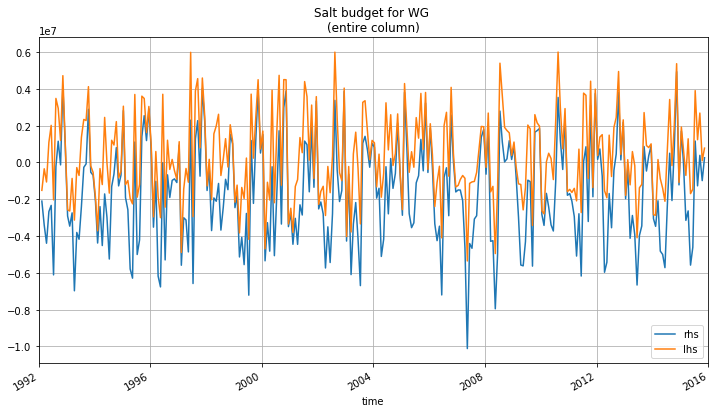

In [110]:
plt.figure(figsize=(12,6))
rhs = - adv_flux[1:287] - diff_flux[1:287] + surface_term[1:287]
lhs = totstend_weddell
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend(loc=4)
plt.grid()
plt.title('Salt budget for WG \n(entire column)')
plt.xlim('1992', '2016');

In [77]:
rhs_terms = xr.merge([adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      surface_term.rename('surf_flux')])

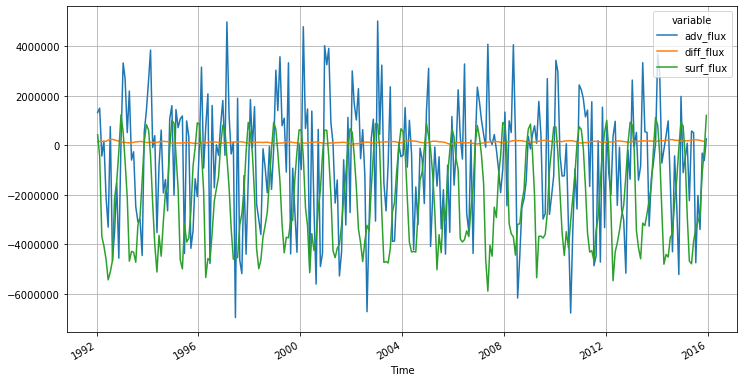

In [80]:
plt.figure(figsize=(12,6))
rhs_terms.to_array().plot.line(x='time')
plt.grid();

## Salt budget for Lower WG (-2,046m to bottom)

In [10]:
sss_mean_lower = ds.SALT.isel(k=36).mean(dim='time').load()

In [11]:
surface_mask_lower = (coords.hFacC.isel(k=36)>0).load()

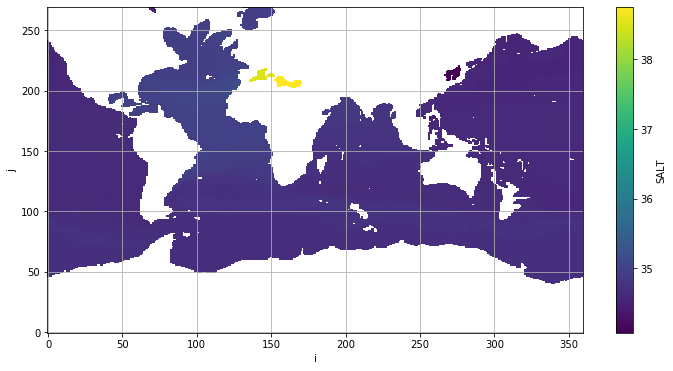

In [12]:
sss_mean_lower.where(surface_mask_lower).plot(figsize=(12,6))
plt.grid();

In [13]:
sss_mean_wg_lower = sss_mean_lower.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg_lower = surface_mask_lower.sel(i=slice(75, 167), j=slice(35, 75))

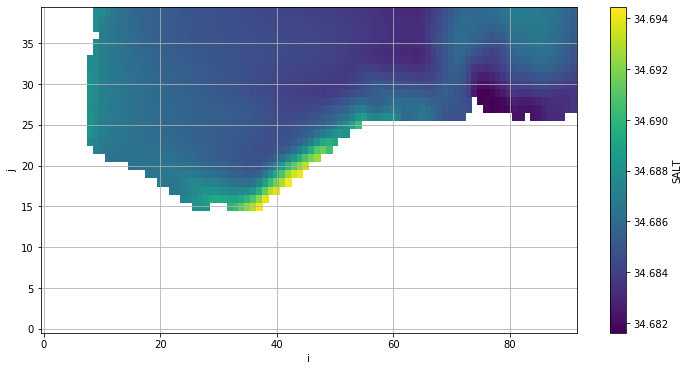

In [14]:
sss_mean_wg_lower.where(surface_mask_wg_lower).plot(figsize=(12,6))
plt.grid();

In [15]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

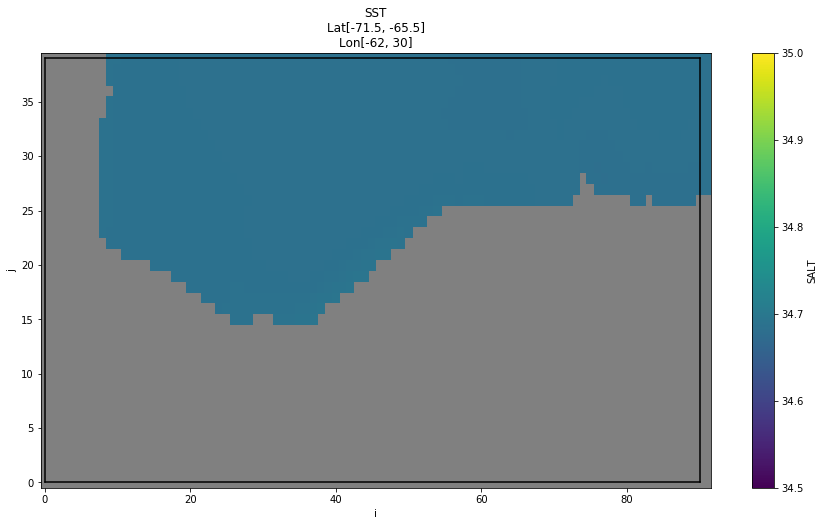

In [33]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sss_mean_wg_lower.where(surface_mask_wg_lower).plot(ax=ax,  vmin=34.5, vmax=35)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [17]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167


lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [18]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [44]:
#advective flux
adv_flux_y_lower = ds.ADVy_SLT.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
adv_flux_x_lower = ds.ADVx_SLT.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
adv_flux_z_lower = ds.ADVr_SLT.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([-1912068.,  -488720.,  3057516., ...,  -643000., -2627502., -6634451.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

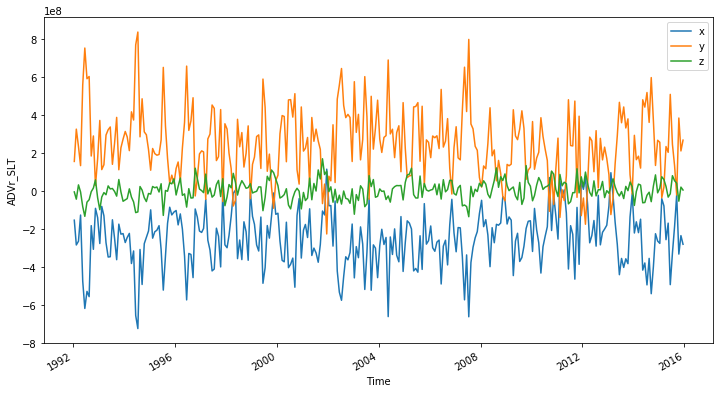

In [37]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [43]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_SLT.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
diff_flux_x_lower = ds.DFxE_SLT.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
diff_flux_z_lower = ((ds.DFrE_SLT.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])
                    + ds.DFrI_SLT.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([27086.605, 25037.047, 22500.824, ..., 35326.54 , 28413.873, 23220.717],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

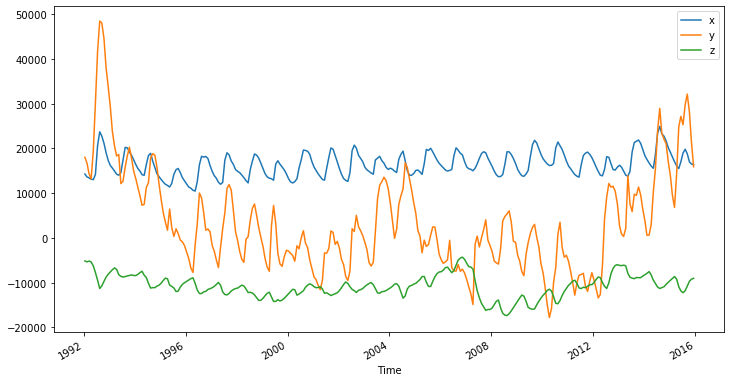

In [22]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [38]:
totstend_weddell_lower = (salt_tend * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['i', 'j','k'])
totstend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 286)>
array([  463537.480887, -3079809.806455, -2671610.436961, ...,   173141.53887 ,
         887206.472968,  2712994.87107 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    dt       (time) float64 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06

In [ ]:
totstend_weddell_lower.plot(figsize=(12,6))
plt.grid()

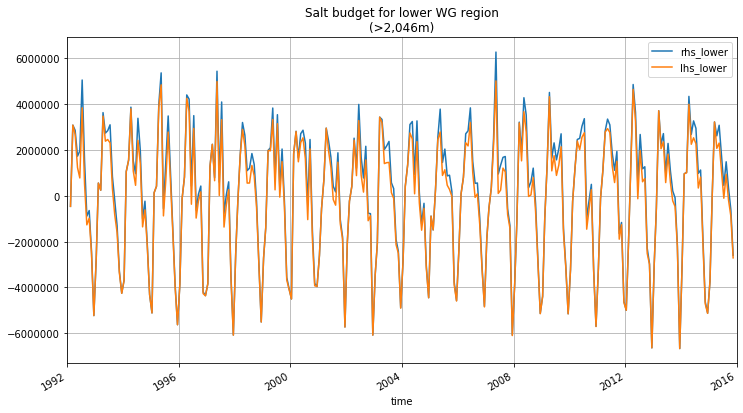

In [101]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower[1:287] + diff_flux_lower[1:287]
lhs_lower = - totstend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid()
plt.title('Salt budget for lower WG region\n(>2,046m)')
plt.xlim('1992', '2016');
#plt.savefig('SOSE-heat-inter-rhs-lhs-timeseries', format='pdf')